# Deep Learning Final Project

Aryaman Shodhan ashodha1,
Trisha Karani \<JHED\>,
Shreya Wadhwa \<JHED\>,
Aidan Aug \<JHED\>

TODO: Include brief description about project

In [1]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
## Standard Library
import os
import json
import re

## External Libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage import io
from skimage.color import rgb2gray
from torchvision import transforms, models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [3]:
use_gpu = torch.cuda.is_available()

## Generator

In [4]:
# Size of the latent space
z_size = 100

# Common factor for number of channels in each layer of the Generator
g_size = 32

# Number of channels in the generated images
n_channels = 3

In [5]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.deconv1 = nn.ConvTranspose2d(z_size, g_size * 32, kernel_size=4, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(g_size * 32)

    self.deconv2 = nn.ConvTranspose2d(g_size * 32, g_size * 16, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(g_size * 16)

    self.deconv3 = nn.ConvTranspose2d(g_size * 16, g_size * 8, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(g_size * 8)

    self.deconv4 = nn.ConvTranspose2d(g_size * 8, g_size * 4, kernel_size=4, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(g_size * 4)

    self.deconv5 = nn.ConvTranspose2d(g_size * 4, g_size * 2, kernel_size=4, stride=2, padding=1)
    self.bn5 = nn.BatchNorm2d(g_size * 2)

    self.deconv6 = nn.ConvTranspose2d(g_size * 2, g_size, kernel_size=4, stride=2, padding=1)
    self.bn6 = nn.BatchNorm2d(g_size)

    self.deconv_out = nn.ConvTranspose2d(g_size, n_channels, kernel_size=4, stride=2, padding=1)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    x = self.bn1(self.deconv1(x))
    x = self.relu(x)
    
    x = self.bn2(self.deconv2(x))
    x = self.relu(x)
    
    x = self.bn3(self.deconv3(x))
    x = self.relu(x)
    
    x = self.bn4(self.deconv4(x))
    x = self.relu(x)
    
    x = self.bn5(self.deconv5(x))
    x = self.relu(x)
    
    x = self.bn6(self.deconv6(x))
    x = self.relu(x)
    
    x = self.deconv_out(x)
    x = self.sigmoid(x)
    
    return x

# Data Preprocessing

TODO: INCLUDE THE STEPS PERFORMED FOR PREPROCESSING THE DATA

Eg. Augmentations, split into train val test, etc.

In [6]:
data_dir = "/content/gdrive/MyDrive/Deep_Learning/archive"

data = []
for root, _, files in os.walk(data_dir):
  files = sorted(filter(lambda x: re.search("endo.png$", x) is not None, files))
  for idx in range(len(files)):
    data.append(os.path.join(root, files[idx]))

random.shuffle(data)

In [7]:
train_datapoints = random.sample(data, 450)
val_datapoints = random.sample(data, 50)
test_datapoints = random.sample(data, 50)

In [8]:
class ImageDataset(Dataset):
  def __init__(self, data, generator, batch_size, num_fake_samples, transforms=None):
    self.data = data
    self.transforms = transforms
    self.generator = generator
    self.num_fake_samples = num_fake_samples
    self.batch_size = batch_size
    self.grayscale = torchvision.transforms.Grayscale()

    self.z_noise = torch.randn((self.batch_size, z_size)).view(-1, z_size, 1, 1)

    for i in range(self.num_fake_samples // self.batch_size):
      fake_imgs = generator(self.z_noise)
      for j in range(batch_size):
        self.data.append(fake_imgs[j].detach())
    
    random.shuffle(self.data)
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    if (type(self.data[idx]) == str):
      target = io.imread(self.data[idx])
      input = rgb2gray(target)
    else:
      target = self.data[idx]
      input = self.grayscale(target)

    if self.transforms:
      if (type(self.data[idx]) == str):
        input, target = self.img_transform(input, target)
    
    input = input.repeat(3, 1, 1).to(torch.float32)
    return input, target

  def img_transform(self, input, target):
    input = self.transforms(input)
    target = self.transforms(target)
    return input, target

In [9]:
train_batch_size = 10
validation_batch_size = 10
test_batch_size = 1

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(300, 525)),
  transforms.CenterCrop(size=256)
])

######

generator = torch.load("/content/gdrive/MyDrive/Deep_Learning/saved_models/models/GAN_generator.pt")
generator = generator.cpu()

train_dataset = ImageDataset(train_datapoints, generator, train_batch_size, num_fake_samples=450, transforms=img_transforms)
val_dataset = ImageDataset(val_datapoints, generator, validation_batch_size, num_fake_samples=100, transforms=img_transforms)
test_dataset = ImageDataset(test_datapoints, generator, test_batch_size, num_fake_samples=100, transforms=img_transforms)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

90
15
150


In [10]:
def visualize_input(dataloader, n_batches=1, n_samples=1):
  pil_transform = transforms.ToPILImage()
  for _ in range(n_batches):
    inputs, targets = next(iter(dataloader))
    for i in range(n_samples):
      input = pil_transform(inputs[i])
      target = pil_transform(targets[i])
      
      fig, ax = plt.subplots(1, 2, figsize=(9, 3))
      ax[0].imshow(np.asarray(input))
      ax[0].set_title("Input Grayscale Image")    

      ax[1].imshow(np.asarray(target))
      ax[1].set_title("Ground Truth Colored Image")

    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


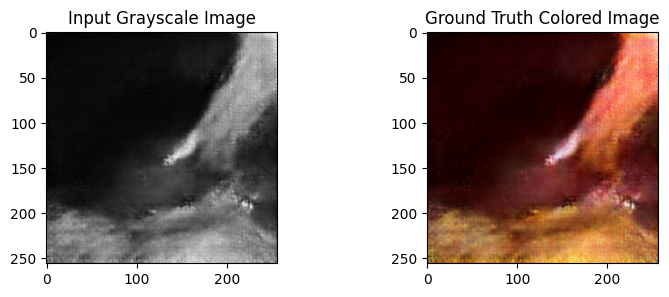

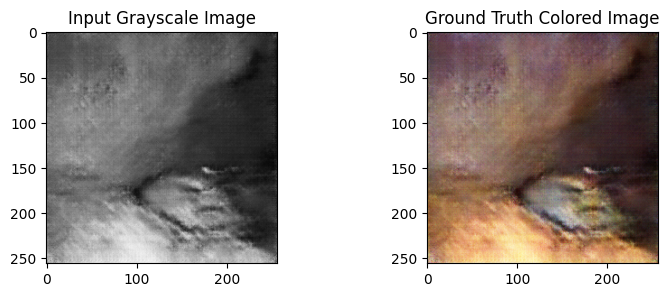

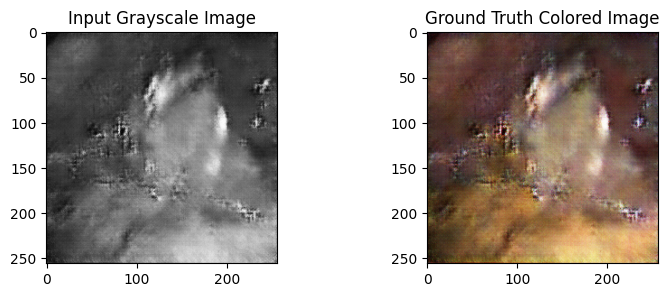

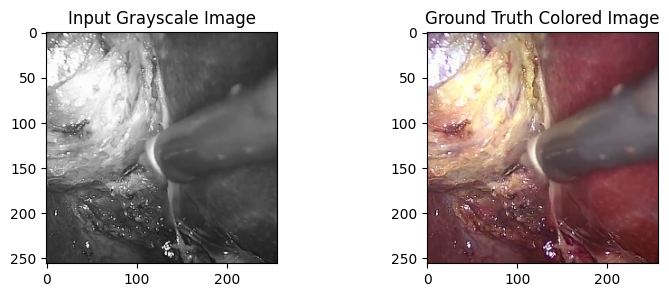

In [11]:
visualize_input(train_dataloader, n_samples=4)

# Training and Validation

In [12]:
def visualize_predictions(dataloader, model, n_batches=1, n_samples=1, use_gpu=False, mode="train"):
  if (mode == "test"):
    model.eval()
  with torch.no_grad():
    pil_transform = transforms.ToPILImage()
    for _ in range(n_batches):
      inputs, targets = next(iter(dataloader))

      if use_gpu:
        inputs = inputs.cuda()
        targets = targets.cuda()
      
      predictions = model(inputs)
      if (not isinstance(model, UNET)): 
        predictions = predictions['out']

      for i in range(n_samples): 
        input = pil_transform(inputs[i])
        target = pil_transform(targets[i])
        prediction = pil_transform(predictions[i])

        fig, ax = plt.subplots(1, 3, figsize=(9, 3))
        ax[0].imshow(np.asarray(input))
        ax[0].set_title("Input Grayscale Image")    

        ax[1].imshow(np.asarray(target))
        ax[1].set_title("Ground Truth Colorization")

        ax[2].imshow(np.asarray(prediction))
        ax[2].set_title("Predicted Colorization")

      plt.show()

In [13]:
def train(model, loss_f, optimizer, scheduler, train_dataloader, val_dataloader, epochs=20, use_gpu=False, **kwargs):
  train_losses = []
  val_losses = []
  print("Start Training...")
  for epoch in range(epochs):
    print("\nEPOCH " + str(epoch + 1) + " of " + str(epochs) + "\n")

    ########################### Training #####################################
    epoch_train_loss = 0
    epoch_train_total = 0
    for i, (train_images, train_targets) in enumerate(train_dataloader):
      model.train()
      if use_gpu:
        train_images = train_images.cuda()
        train_targets = train_targets.cuda()

      if (i > 0 or epoch > 0):
        optimizer.zero_grad()
      
      train_predictions = model(train_images)
      if (not isinstance(model, UNET)):
        train_predictions = train_predictions['out']

      train_loss = loss_f.forward(train_predictions, train_targets)
      train_loss.backward()

      epoch_train_loss += train_loss.item()
      epoch_train_total += train_targets.shape[0]

      optimizer.step()
    
    train_losses.append(epoch_train_loss / epoch_train_total)

    ########################### Validation #####################################
    epoch_val_loss = 0
    epoch_val_total = 0
    for val_images, val_targets in val_dataloader:

      if use_gpu:
        val_images = val_images.cuda()
        val_targets = val_targets.cuda()
      
      val_predictions = model(val_images)
      if (not isinstance(model, UNET)):
        val_predictions = val_predictions['out']

      val_loss = loss_f.forward(val_predictions, val_targets)

      epoch_val_loss += val_loss.item()
      epoch_val_total += val_targets.shape[0]
    
    val_losses.append(epoch_val_loss / epoch_val_total)

    scheduler.step()

    print("Training loss: %f" % (epoch_train_loss / epoch_train_total))
    print("Validation loss: %f" % (epoch_val_loss / epoch_val_total))
    visualize_predictions(train_dataloader, model, use_gpu=use_gpu)

  plt.figure()
  plt.plot(train_losses, label="Training")
  plt.plot(val_losses, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

## UNET

In [14]:
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=True):
  if useBN:
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(dim_out),
        nn.LeakyReLU(0.1),
        nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(dim_out),
        nn.LeakyReLU(0.1)
    )
  return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
  )

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
      nn.ConvTranspose2d(ch_coarse, ch_fine, kernel_size=4, stride=2, padding=1, bias=False),
      nn.ReLU()
  )

In [15]:
class UNET(nn.Module):

  def __init__(self, n_classes, useBN=True):
    super(UNET, self).__init__()
    # Downgrade Stages
    self.conv1 = add_conv_stage(dim_in=3, dim_out=32, useBN=useBN)
    self.conv2 = add_conv_stage(dim_in=32, dim_out=64, useBN=useBN)
    self.conv3 = add_conv_stage(dim_in=64, dim_out=128, useBN=useBN)
    self.conv4 = add_conv_stage(dim_in=128, dim_out=256, useBN=useBN)

    # Upgrade Stages
    self.conv3m = add_conv_stage(dim_in=256, dim_out=128, useBN=useBN)
    self.conv2m = add_conv_stage(dim_in=128, dim_out=64, useBN=useBN)
    self.conv1m = add_conv_stage(dim_in=64, dim_out=32, useBN=useBN)

    # Maxpool
    self.max_pool = nn.MaxPool2d(kernel_size=2)

    # Upsample Layers
    self.upsample43 = upsample(ch_coarse=256, ch_fine=128)
    self.upsample32 = upsample(ch_coarse=128, ch_fine=64)
    self.upsample21 = upsample(ch_coarse=64, ch_fine=32)

    # Final Layer
    self.final_layer = nn.Conv2d(32, n_classes, kernel_size=1)
    self.final_activation = nn.ReLU()

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), dim=1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), dim=1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), dim=1)
    conv1m_out = self.conv1m(conv2m_out_)

    conv_out = self.final_activation(self.final_layer(conv1m_out))

    return conv_out

In [16]:
n_classes = 3
lr = 0.001
epochs = 50

model = UNET(n_classes=n_classes)
if use_gpu:
  model = model.cuda()

for m in model.modules():
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    if m.bias is not None:
      m.bias.data.zero_()

print(model.parameters)

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

<bound method Module.parameters of UNET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [17]:
train(model, loss_f, optimizer, scheduler, train_dataloader, val_dataloader, epochs=epochs, use_gpu=use_gpu)

Output hidden; open in https://colab.research.google.com to view.

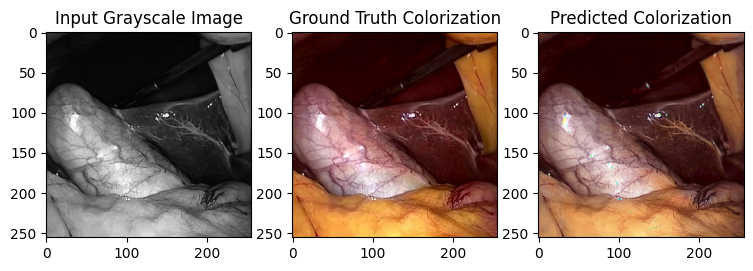

In [18]:
visualize_predictions(test_dataloader, model, n_batches=1, use_gpu=use_gpu, mode="test")

In [19]:
torch.save(model, "/content/gdrive/MyDrive/Deep_Learning/saved_models/models/unet_GAN_image_recolorization.pt")

## DeepLabV3

In [20]:
n_classes = 3
lr = 0.001
epochs = 50

model = torchvision.models.segmentation.deeplabv3_resnet50()
model.classifier[4] = nn.Conv2d(256, n_classes, kernel_size=1, stride=1)

if use_gpu:
  model = model.cuda()

for m in model.modules():
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    if m.bias is not None:
      m.bias.data.zero_()

print(model.parameters)

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.1MB/s]


<bound method Module.parameters of DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inp

In [21]:
train(model, loss_f, optimizer, scheduler, train_dataloader, val_dataloader, epochs=epochs, use_gpu=use_gpu)

Output hidden; open in https://colab.research.google.com to view.

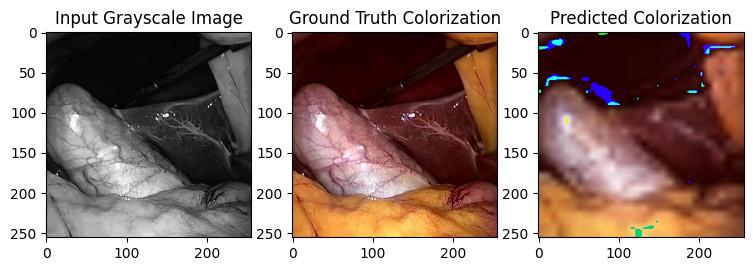

In [22]:
visualize_predictions(test_dataloader, model, n_batches=1, use_gpu=use_gpu, mode="test")

In [23]:
torch.save(model, "/content/gdrive/MyDrive/Deep_Learning/saved_models/models/deep_lab_GAN_image_recolorization.pt")


## FCN

In [24]:
n_classes = 3
lr = 0.001
epochs = 50

model = torchvision.models.segmentation.fcn_resnet50()
model.classifier[4] = nn.Conv2d(512, n_classes, kernel_size=1, stride=1)

if use_gpu:
  model = model.cuda()

for m in model.modules():
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    if m.bias is not None:
      m.bias.data.zero_()

print(model.parameters)

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

<bound method Module.parameters of FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=T

In [25]:
train(model, loss_f, optimizer, scheduler, train_dataloader, val_dataloader, epochs=epochs, use_gpu=use_gpu)

Output hidden; open in https://colab.research.google.com to view.

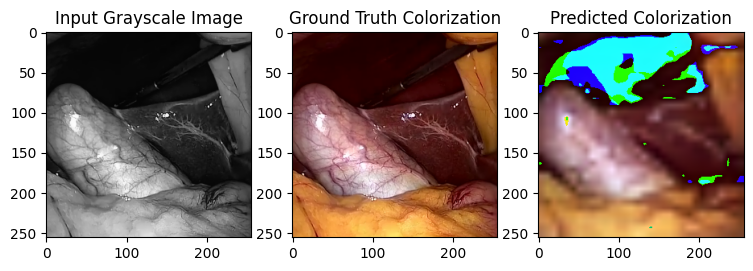

In [26]:
visualize_predictions(test_dataloader, model, n_batches=1, use_gpu=use_gpu, mode="test")

In [27]:
torch.save(model, "/content/gdrive/MyDrive/Deep_Learning/saved_models/models/fcn_GAN_image_recolorization.pt")

## Evaluate each of the Models

In [28]:
def eval_test(model, loss_f, test_dataloader, use_gpu=False):
  model.eval()

  with torch.no_grad():
    test_loss = 0
    test_total = 0
    for inputs, targets in test_dataloader:
      if use_gpu:
        inputs = inputs.cuda()
        targets = targets.cuda()

      predictions = model(inputs)
      if (not isinstance(model, UNET)):
        predictions = predictions['out']
      
      test_loss += loss_f.forward(predictions, targets).item()
      test_total += targets.shape[0]

    print("Test loss: %f" % (test_loss / test_total))

In [29]:
loss_f = nn.MSELoss()

### UNET

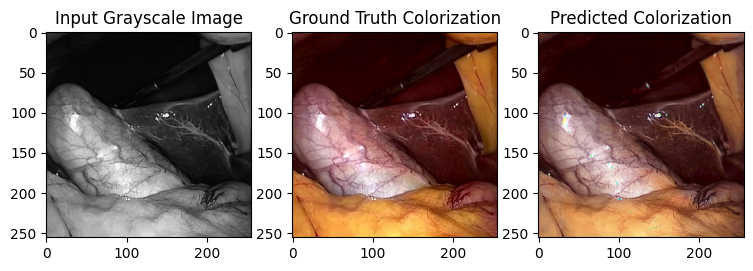

Test loss: 0.002274


In [30]:
unet = torch.load("/content/gdrive/MyDrive/Deep_Learning/saved_models/models/unet_GAN_image_recolorization.pt")

visualize_predictions(test_dataloader, unet, n_batches=1, use_gpu=use_gpu, mode="test")
eval_test(unet, loss_f, test_dataloader, use_gpu=use_gpu)

### Deep Lab V3

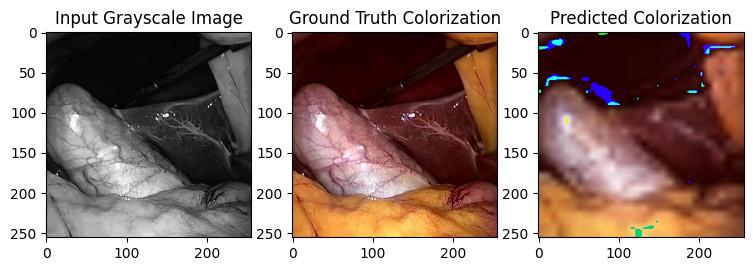

Test loss: 0.004248


In [31]:
deep_lab = torch.load("/content/gdrive/MyDrive/Deep_Learning/saved_models/models/deep_lab_GAN_image_recolorization.pt")

visualize_predictions(test_dataloader, deep_lab, n_batches=1, use_gpu=use_gpu, mode="test")
eval_test(deep_lab, loss_f, test_dataloader, use_gpu=use_gpu)

### FCN

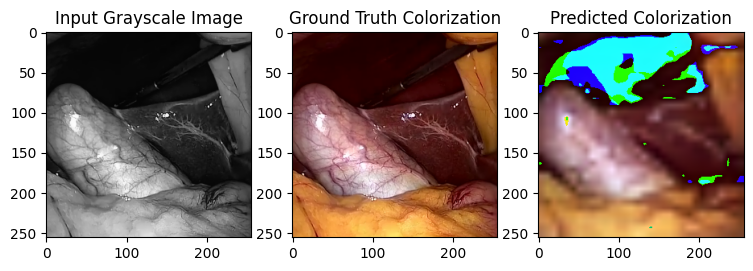

Test loss: 0.004609


In [32]:
fcn = torch.load("/content/gdrive/MyDrive/Deep_Learning/saved_models/models/fcn_GAN_image_recolorization.pt")

visualize_predictions(test_dataloader, fcn, n_batches=1, use_gpu=use_gpu, mode="test")
eval_test(fcn, loss_f, test_dataloader, use_gpu=use_gpu)